## Introduction

The purpose of the present project is to illustrate the application of web scrapping, Foursquare API and, k-means clustering to segment and explore boroughs in Toronto.
 


## Importing needed packages

During each modeling steps of this project, we will import libraries, as well as packages, as needed.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.html import read_html
import pgeocode
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Estructure a json file into a pandas dataframe
from pandas.io.json import json_normalize
import requests # library to handle requests


# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer

## PART I -  Web scraping, data wrangling and cleaning

Now, we are going to web scrape the following [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) page, to obtain the postal codes, borough, and neighborhood names of Toronto, converting it to a pandas data frame. This data will be used later with the Foursquare API.

In [2]:
# extract tables from wikipedia

webpage = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'


# read_html returns a list of Dataframes. Therefore, you need to specify [0] to select the first item of the list.
# "class":"wikitable" - Just right click over the element of interest of the webpage selecting the inspect option 
# .                     then looking at the name of the class.
df = read_html(webpage,  attrs={"class":"wikitable"})[0]



print ('The extracted table has {rows} rows and {col} columns.'.format(rows=df.shape[0],col=df.shape[1]))

The extracted table has 287 rows and 3 columns.


In [3]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 3 columns):
Postcode         287 non-null object
Borough          287 non-null object
Neighbourhood    287 non-null object
dtypes: object(3)
memory usage: 6.9+ KB


We can observe that we have no missing values. Now, we will proceed to check the unique values found in the columns 'Borough' and, 'Neighbourhood'.

In [5]:
df['Borough'].value_counts()

Not assigned        77
Etobicoke           44
North York          38
Downtown Toronto    37
Scarborough         37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Queen's Park         1
Mississauga          1
Name: Borough, dtype: int64

In [6]:
df['Neighbourhood'].value_counts()

Not assigned                                         78
Runnymede                                             2
St. James Town                                        2
The Junction North                                    1
Summerhill East                                       1
Cliffside                                             1
Forest Hill SE                                        1
North Park                                            1
Henry Farm                                            1
Berczy Park                                           1
Clairlea                                              1
Old Mill South                                        1
Royal York South West                                 1
Woodbine Gardens                                      1
New Toronto                                           1
Royal York South East                                 1
Don Mills North                                       1
Downsview West                                  

As indicated above, at the column Borough 77 strings “Not assigned
” were encountered, while at the column Neighbourhood 78. However, we do not know if these strings appeared simultaneously in both columns. Therefore, we will proceed to investigate before starting to clean the data. 

In [7]:
a = df.loc[(df['Neighbourhood'] == 'Not assigned') & (df['Borough'] == 'Not assigned')]
a

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
8,M8A,Not assigned,Not assigned
12,M2B,Not assigned,Not assigned
19,M7B,Not assigned,Not assigned
20,M8B,Not assigned,Not assigned
29,M2C,Not assigned,Not assigned
35,M7C,Not assigned,Not assigned
36,M8C,Not assigned,Not assigned
44,M2E,Not assigned,Not assigned


In [8]:
len(a)

77

It turns out that all the cells at the Borough columns that are "Not assigned", 77, corresponds to a "Not assigned" cells at the Neighbourhood column. However, the Neighbourhood column has one additional "Not assigned" cell. To overcome this issue, we will proceed as follows:
 
- Drop the rows that have "Not assigned" cells in both columns Borough and Neighbourhood.
- The additional "Not assigned" cell at the column Neighbourhood will be considered equal to the correspond borough cell.


In [9]:
# Dropping the rows that have "Not assigned" cells in both columns Borough and Neighbourhood.

df.drop(df[(df['Neighbourhood'] == 'Not assigned') & (df['Borough'] == 'Not assigned')].index,inplace=True)

# Dropping the current index of the DataFrame and replaces it with an index of increasing integers.

df.reset_index(drop=True, inplace=True)

df.shape

(210, 3)

As expected, 77 rows were dropped in the new dataframe. Let's check the additional "Not assigned" cell at the Neighbourhood column.

In [10]:
df[df['Neighbourhood'] == 'Not assigned']


,Postcode,Borough,Neighbourhood
5,M7A,Queen's Park,Not assigned


Now, the additional "Not assigned" cell at the column Neighbourhood will be considered equal to the correspond borough cell.

In [11]:
df.loc[:,'Neighbourhood'].iloc[6] = df.loc[:,'Borough'].iloc[6]

# Verifying
df.loc[:,'Neighbourhood'].iloc[6]

'Downtown Toronto'

Since more than one neighborhood can exist in one postal code area, we will proceed to combine the rows with the same postal code into one single row, with the neighborhoods separated with a comma. The procedure is described below:

- Verify the existence of duplicated postal code rows.
- Create a dictionary in which the keys are the postal codes and, the values are the neighborhoods separated with a comma for each duplicated key.
- Drop the duplicate rows in the dataframe, letting the first occurrence stays.
- Update the new neighborhood values into the dataframe.

In [12]:
# Verify the existence of duplicated postal code rows.
df.groupby('Postcode')['Neighbourhood'].count()

Postcode
M1B    2
M1C    3
M1E    3
M1G    1
M1H    1
M1J    1
M1K    3
M1L    3
M1M    3
M1N    2
M1P    3
M1R    2
M1S    1
M1T    3
M1V    4
M1W    1
M1X    1
M2H    1
M2J    3
M2K    1
M2L    2
M2M    2
M2N    1
M2P    1
M2R    1
M3A    1
M3B    1
M3C    2
M3H    3
M3J    2
M3K    2
M3L    1
M3M    1
M3N    1
M4A    1
M4B    2
M4C    1
M4E    1
M4G    1
M4H    1
M4J    1
M4K    2
M4L    2
M4M    1
M4N    1
M4P    1
M4R    1
M4S    1
M4T    2
M4V    5
M4W    1
M4X    2
M4Y    1
M5A    1
M5B    2
M5C    1
M5E    1
M5G    1
M5H    3
M5J    3
M5K    2
M5L    2
M5M    2
M5N    1
M5P    2
M5R    3
M5S    2
M5T    3
M5V    7
M5W    1
M5X    2
M6A    2
M6B    1
M6C    1
M6E    1
M6G    1
M6H    2
M6J    2
M6K    3
M6L    3
M6M    4
M6N    2
M6P    2
M6R    2
M6S    2
M7A    1
M7R    1
M7Y    1
M8V    3
M8W    2
M8X    3
M8Y    8
M8Z    5
M9A    1
M9B    5
M9C    4
M9L    1
M9M    2
M9N    1
M9P    1
M9R    4
M9V    8
M9W    1
Name: Neighbourhood, dtype: int64

In [13]:
def PCode_dup(df,duplicated_col_id,col_to_be_changed_id):
    '''
    A function that creates a dictionary in which the keys are the postal codes and, 
    the values are the neighborhoods separated with a comma for each duplicated key.
    '''
        
    P_codes = {}


    for index, row in df.iterrows():
        P_code = row[duplicated_col_id]
        if P_code not in P_codes:
            P_codes[P_code] = row[col_to_be_changed_id]
        else:
            P_codes[P_code] += ',' + row[col_to_be_changed_id]

    print(P_codes)
    
    return P_codes
            
            
PCode_dict = PCode_dup(df,'Postcode','Neighbourhood')

{'M3A': 'Parkwoods', 'M4A': 'Victoria Village', 'M5A': 'Harbourfront', 'M6A': 'Lawrence Heights,Lawrence Manor', 'M7A': 'Not assigned', 'M9A': 'Downtown Toronto', 'M1B': 'Rouge,Malvern', 'M3B': 'Don Mills North', 'M4B': 'Woodbine Gardens,Parkview Hill', 'M5B': 'Ryerson,Garden District', 'M6B': 'Glencairn', 'M9B': 'Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park', 'M1C': 'Highland Creek,Rouge Hill,Port Union', 'M3C': 'Flemingdon Park,Don Mills South', 'M4C': 'Woodbine Heights', 'M5C': 'St. James Town', 'M6C': 'Humewood-Cedarvale', 'M9C': 'Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe', 'M1E': 'Guildwood,Morningside,West Hill', 'M4E': 'The Beaches', 'M5E': 'Berczy Park', 'M6E': 'Caledonia-Fairbanks', 'M1G': 'Woburn', 'M4G': 'Leaside', 'M5G': 'Central Bay Street', 'M6G': 'Christie', 'M1H': 'Cedarbrae', 'M2H': 'Hillcrest Village', 'M3H': 'Bathurst Manor,Downsview North,Wilson Heights', 'M4H': 'Thorncliffe Park', 'M5H': 'Adelaide,King,Richmond', 'M6H': 'Dover

In [14]:
# Removing the duplicates of the Postcode column, keeping the first occurrence.
df = df.drop_duplicates(subset='Postcode', keep='first')
df.shape

(103, 3)

In [15]:
# Keys values
PCode_dict.keys()

dict_keys(['M3A', 'M4A', 'M5A', 'M6A', 'M7A', 'M9A', 'M1B', 'M3B', 'M4B', 'M5B', 'M6B', 'M9B', 'M1C', 'M3C', 'M4C', 'M5C', 'M6C', 'M9C', 'M1E', 'M4E', 'M5E', 'M6E', 'M1G', 'M4G', 'M5G', 'M6G', 'M1H', 'M2H', 'M3H', 'M4H', 'M5H', 'M6H', 'M1J', 'M2J', 'M3J', 'M4J', 'M5J', 'M6J', 'M1K', 'M2K', 'M3K', 'M4K', 'M5K', 'M6K', 'M1L', 'M2L', 'M3L', 'M4L', 'M5L', 'M6L', 'M9L', 'M1M', 'M2M', 'M3M', 'M4M', 'M5M', 'M6M', 'M9M', 'M1N', 'M2N', 'M3N', 'M4N', 'M5N', 'M6N', 'M9N', 'M1P', 'M2P', 'M4P', 'M5P', 'M6P', 'M9P', 'M1R', 'M2R', 'M4R', 'M5R', 'M6R', 'M7R', 'M9R', 'M1S', 'M4S', 'M5S', 'M6S', 'M1T', 'M4T', 'M5T', 'M1V', 'M4V', 'M5V', 'M8V', 'M9V', 'M1W', 'M4W', 'M5W', 'M8W', 'M9W', 'M1X', 'M4X', 'M5X', 'M8X', 'M4Y', 'M7Y', 'M8Y', 'M8Z'])

In [16]:
# Update the new neighborhood values into the dataframe.

for index, row in df.iterrows():
    if row['Postcode'] in PCode_dict.keys():
        row['Neighbourhood'] = PCode_dict[row['Postcode']]

In [17]:
# Verifying
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
5,M7A,Queen's Park,Not assigned


In [18]:
#Verifying
df.tail()

,Postcode,Borough,Neighbourhood
192,M8X,Etobicoke,"The Kingsway,Montgomery Road,Old Mill North"
195,M4Y,Downtown Toronto,Church and Wellesley
196,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern
197,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout..."
205,M8Z,Etobicoke,"Kingsway Park South West,Mimico NW,The Queensw..."


## PART II - Geographical coordinates


Now, we will proceed by getting the geographical coordinates of each postal code. For the present project, we are interested in a reliable free package. Since the [Google Maps Geocoding API started charging](https://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike) we have excluded this option. We have tested the [Geocoder Python package](https://geocoder.readthedocs.io/) with the following piece of code:

__lat_lng_coords = None__  

__while(lat_lng_coords is None):__  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))__  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__lat_lng_coords = g.latlng__  

__latitude = lat_lng_coords[0]__  
__longitude = lat_lng_coords[1]__  

However, this Package has a problem in which we have to be persistent (while loop), in a sense that we can make a call and the result would None, and then make a call again and get the coordinates. Unfortunately, even with the while loop, the Geocoder Python package was very unreliable. Finally, a very good alternative used here was the [Pgeocode Python library](https://pgeocode.readthedocs.io/en/latest/index.html) designed for high-performance off-line querying of GPS coordinates, region name and municipality name from postal codes. This package has the advantage of returning a pandas.DataFrame, as a result of a geo-location query, the content of its columns are described below:

- country code: iso country code, 2 characters.
- postal code : postal code.
- place name : place name (e.g. town, city, etc).
- state_name : 1. order subdivision (state).
- state_code : 1. order subdivision (state).
- county_name : 2. order subdivision (county/province).
- county_code : 2. order subdivision (county/province).
- community_name : 3. order subdivision (community).
- community_code : 3. order subdivision (community).
- latitude : estimated latitude.
- longitude : estimated longitude.
- accuracy : accuracy of lat/lng from 1=estimated to 6=centroid.

In [19]:
# Get locations information from postal codes

nomi = pgeocode.Nominatim('CA')
nomi.query_location('Toronto,Ontario')

List_pcodes = list(df.Postcode)
df2 = nomi.query_postal_code(List_pcodes)
df2

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,M3A,CA,North York (York Heights / Victoria Village / ...,Ontario,ON,North York,NaN,NaN,NaN,43.7545,-79.3300,1.0
1,M4A,CA,North York (Sweeney Park / Wigmore Park),Ontario,ON,NaN,NaN,NaN,NaN,43.7276,-79.3148,6.0
2,M5A,CA,Downtown Toronto (Regent Park / Port of Toronto),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6555,-79.3626,6.0
3,M6A,CA,North York (Lawrence Manor / Lawrence Heights),Ontario,ON,North York,NaN,NaN,NaN,43.7223,-79.4504,6.0
4,M7A,CA,Queen's Park Ontario Provincial Government,Ontario,ON,NaN,NaN,NaN,NaN,43.6641,-79.3889,NaN
5,M9A,CA,Etobicoke (Islington Avenue),Ontario,ON,Etobicoke,NaN,NaN,NaN,43.6662,-79.5282,6.0
6,M1B,CA,Scarborough (Malvern / Rouge River),Ontario,ON,Scarborough,NaN,NaN,NaN,43.8113,-79.1930,6.0
7,M3B,CA,Don Mills North,Ontario,ON,Don Mills,NaN,NaN,NaN,43.7450,-79.3590,4.0
8,M4B,CA,East York (Parkview Hill / Woodbine Gardens),Ontario,ON,East York,NaN,NaN,NaN,43.7063,-79.3094,6.0
9,M5B,CA,Downtown Toronto (Ryerson),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6572,-79.3783,6.0


In [20]:
# Rename the postal codes collumn according to df

df2.rename(columns={'postal_code': 'Postcode'},inplace=True)
df2.head()

,Postcode,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,M3A,CA,North York (York Heights / Victoria Village / ...,Ontario,ON,North York,NaN,NaN,NaN,43.7545,-79.3300,1.0
1,M4A,CA,North York (Sweeney Park / Wigmore Park),Ontario,ON,NaN,NaN,NaN,NaN,43.7276,-79.3148,6.0
2,M5A,CA,Downtown Toronto (Regent Park / Port of Toronto),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6555,-79.3626,6.0
3,M6A,CA,North York (Lawrence Manor / Lawrence Heights),Ontario,ON,North York,NaN,NaN,NaN,43.7223,-79.4504,6.0
4,M7A,CA,Queen's Park Ontario Provincial Government,Ontario,ON,NaN,NaN,NaN,NaN,43.6641,-79.3889,NaN


In [21]:
df2.shape

(103, 12)

Now, we will proceed connecting the rows of df and df2 based on the postal codes.

In [22]:
# Join df and df2 using the Postcode column as the key
df3=pd.merge(df,df2,on='Postcode')
df3.head()

,Postcode,Borough,Neighbourhood,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,M3A,North York,Parkwoods,CA,North York (York Heights / Victoria Village / ...,Ontario,ON,North York,NaN,NaN,NaN,43.7545,-79.3300,1.0
1,M4A,North York,Victoria Village,CA,North York (Sweeney Park / Wigmore Park),Ontario,ON,NaN,NaN,NaN,NaN,43.7276,-79.3148,6.0
2,M5A,Downtown Toronto,Harbourfront,CA,Downtown Toronto (Regent Park / Port of Toronto),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6555,-79.3626,6.0
3,M6A,North York,"Lawrence Heights,Lawrence Manor",CA,North York (Lawrence Manor / Lawrence Heights),Ontario,ON,North York,NaN,NaN,NaN,43.7223,-79.4504,6.0
4,M7A,Queen's Park,Not assigned,CA,Queen's Park Ontario Provincial Government,Ontario,ON,NaN,NaN,NaN,NaN,43.6641,-79.3889,NaN


In [23]:
df3.shape

(103, 14)

In [24]:
# Simplifying the dataframe

df3.drop(['country code','place_name','state_name','state_code','county_name','county_code','community_name'\
          ,'community_code','accuracy'], axis=1, inplace= True)


df3.head()

,Postcode,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,Harbourfront,43.6555,-79.3626
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.7223,-79.4504
4,M7A,Queen's Park,Not assigned,43.6641,-79.3889


Now, let us check if there are any missing values.

In [25]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 5 columns):
Postcode         103 non-null object
Borough          103 non-null object
Neighbourhood    103 non-null object
latitude         102 non-null float64
longitude        102 non-null float64
dtypes: float64(2), object(3)
memory usage: 4.8+ KB


We can observe that we have in our dataframe one missing value for latitude and another for longitude which is probably in the same row. Therefore, let us verify this hypothesis.

In [26]:
df3.loc[(df3.latitude.isnull()) & (df3.longitude.isnull())]

,Postcode,Borough,Neighbourhood,latitude,longitude
76,M7R,Mississauga,Canada Post Gateway Processing Centre,NaN,NaN


In [27]:
# Dropping missing values
df3.dropna(inplace=True)
df3.reset_index(drop=True, inplace=True)

df3.shape

(102, 5)

## PART III - Geospatial analysis in Toronto

FALAR SOBRE O Q FAREI (...)

At this point, we will use the highly intuitive folium library, which allows us to interactively (leaflet map) visualize spatial data that has been manipulated so far. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map. The library has several built-in tilesets from OpenStreetMap, Mapbox, and Stamen, and supports custom tilesets with Mapbox or Cloudmade API keys. Furthermore, it supports both Image, Video, GeoJSON, and TopoJSON overlays (check this documentation [link](https://python-visualization.github.io/folium) for further details).


Let us start our analysis by creating a map of Toronto using latitude and longitude values from our dataframe as markers.

In [28]:
lat_downtown_Toronto = df3.loc[2,'latitude']
lng_downtown_Toronto = df3.loc[2,'longitude']

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[lat_downtown_Toronto, lng_downtown_Toronto], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3.latitude, df3.longitude, df3.Borough, df3.Neighbourhood):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Foursquare credentials

To access Foursquare data, it is necessary specific credentials. Therefore, first, we need to create a Foursquare account, then create a developer account at this [website](https://developer.foursquare.com), after that we will fill a form with the app description, then you can create an app. After all this process, you will have access to the specific credentials and can start making calls to the API and retrieving data


We will not show the Foursquare credentials for this application here. Because they are unique for each program, and this information would be a security breach, in which anyone would be able to manipulate and probably abuse this program. Therefore, this information will be imported from a .py file, at the same directory as this Jupiter notebook, in the following format:

__CLIENT_ID = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"__  
__CLIENT_SECRET = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"__  
__VERSION = '"XXXXXXXXXXXX"__


In [29]:
# Importing user credentials

import Credentials_to_access_Foursquare


client_ID = Credentials_to_access_Foursquare.CLIENT_ID
client_secret = Credentials_to_access_Foursquare.CLIENT_SECRET
version = Credentials_to_access_Foursquare.VERSION

## Exploring Downtown Toronto

Before a deep dive into our analysis, let us start by exploring the borough of Downtown Toronto of our dataframe. Our purpose here is getting the top 100 venues that are in Downtown Toronto within a radius of 500 meters.

In [30]:
# Limit of the number of venues returned by Foursquare API
LIMIT = 100

# Define radius
radius = 500 

# Create the Foursquare GET request URL.
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(client_ID, client_secret, version, lat_downtown_Toronto, lng_downtown_Toronto, radius, LIMIT)

# Send the GET request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5df0b0ab542890001b75fc98'},
 'response': {'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 25,
  'suggestedBounds': {'ne': {'lat': 43.660000004500006,
    'lng': -79.3563918719477},
   'sw': {'lat': 43.6509999955, 'lng': -79.36880812805231}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '53b8466a498e83df908c3f21',
       'name': 'Tandem Coffee',
       'location': {'address': '368 King St E',
        'crossStreet': 'at Trinity St',
        'lat': 43.65355870959944,
        'lng': -79.36180945913513,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65355870959944,
          'lng': -79.36180945913513}],
        'distance': 225

Now, we will extract the useful information of the json file contained in the items key, and structure it into a pandas dataframe.

In [31]:
# Extract the useful information of the json file contained in the items key

venues = results['response']['groups'][0]['items']

# Normalize semi-structured JSON data into a flat table.
nearby_venues = json_normalize(venues)

# Filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]



nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Tandem Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.653559,-79.361809
1,Roselle Desserts,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",43.653447,-79.362017
2,Figs Breakfast & Lunch,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.655675,-79.364503
3,Cocina Economica,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.654959,-79.365657
4,Morning Glory Cafe,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.653947,-79.361149


Each item of the column venue.categories is a dictionary to extract this information we will use the following function:

In [32]:
# Function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
# Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Tandem Coffee,Coffee Shop,43.653559,-79.361809
1,Roselle Desserts,Bakery,43.653447,-79.362017
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,Cocina Economica,Mexican Restaurant,43.654959,-79.365657
4,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


In [33]:
# Clean columns names
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

nearby_venues.head()

25 venues were returned by Foursquare.


,name,categories,lat,lng
0,Tandem Coffee,Coffee Shop,43.653559,-79.361809
1,Roselle Desserts,Bakery,43.653447,-79.362017
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,Cocina Economica,Mexican Restaurant,43.654959,-79.365657
4,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


## Explore Boroughs in Toronto

Now, we will create a function to extend the previous analysis to all boroughs of Toronto presented in our dataframe.

In [34]:
###################################################################################################
### Purpose: It returns data in a dataframe format from several venues of a particular borough. ###
###################################################################################################

def getNearbyVenues(names, latitudes, longitudes, CLIENT_ID, CLIENT_SECRET, VERSION, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        '''
        - It iterates over each venue's information encountered for that particular borough.
        - Each item appended to the venues_list list for one iteration of the for loop has the 
        same borough name, lat and long, and different information for each venue.
        '''
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    # Create a pandas dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    # Set the columns labels
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
Toronto_venues = getNearbyVenues(names=df3['Borough'], latitudes=df3['latitude'],longitudes=df3['longitude'],
                                 CLIENT_ID=client_ID,CLIENT_SECRET=client_secret,VERSION=version)

North York
North York
Downtown Toronto
North York
Queen's Park
Downtown Toronto
Scarborough
North York
East York
Downtown Toronto
North York
Etobicoke
Scarborough
North York
East York
Downtown Toronto
York
Etobicoke
Scarborough
East Toronto
Downtown Toronto
York
Scarborough
East York
Downtown Toronto
Downtown Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
North York
North York
Scarborough
North York
North York
East Toronto
North York
York
North York
Scarborough
North York
North York
Central Toronto
Central Toronto
York
York
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
Central Toronto
Downtown Toronto
West Toronto
Scarbo

In [36]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2290, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,43.7545,-79.3300,Brookbanks Park,43.751976,-79.332140,Park
1,North York,43.7545,-79.3300,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,North York,43.7276,-79.3148,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,North York,43.7276,-79.3148,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,North York,43.7276,-79.3148,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [37]:
Toronto_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 7 columns):
Borough              2290 non-null object
Borough Latitude     2290 non-null float64
Borough Longitude    2290 non-null float64
Venue                2290 non-null object
Venue Latitude       2290 non-null float64
Venue Longitude      2290 non-null float64
Venue Category       2290 non-null object
dtypes: float64(4), object(3)
memory usage: 125.4+ KB


No missing values encountered.

In [38]:
print('There are {} uniques venues categories.'.format(len(Toronto_venues['Venue Category'].unique())))

# Number of venues per borough

Toronto_venues.groupby('Borough').count()

There are 267 uniques venues categories.


,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Central Toronto,76,76,76,76,76,76
Downtown Toronto,1245,1245,1245,1245,1245,1245
East Toronto,90,90,90,90,90,90
East York,77,77,77,77,77,77
Etobicoke,93,93,93,93,93,93
North York,314,314,314,314,314,314
Queen's Park,34,34,34,34,34,34
Scarborough,119,119,119,119,119,119
West Toronto,210,210,210,210,210,210


We can observe that the number of venues of Downtown Toronto is greater than the number of venues data retrieved for all the other boroughs together.

This time we are going to focus on the category of the venues, the idea here is verifying the most common venues by borough.

In [39]:
# Data Wrangling

# Convert categorical variable into dummy/indicator variables
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add the borough column back to dataframe
Toronto_onehot['Borough'] = Toronto_venues['Borough'] 

# Move borough column to the first column
columns_position = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[columns_position]

print(Toronto_onehot.shape)
Toronto_onehot.head()

(2290, 268)


,Borough,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Now, we will apply the split-apply-combine methodology by splitting the data of the previous dataframe, on its rows, into groups based on the boroughs. After that, we will calculate the mean of the frequency of the occurrence of each venue category.

In [40]:
# The mean of the frequency of occurrence of each category

Toronto_grouped = Toronto_onehot.groupby('Borough').mean().reset_index()

print(Toronto_grouped.shape)
Toronto_grouped

(10, 268)


,Borough,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0.000000,0.000000,0.000000,0.039474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013

Now, we will proceed with printing the top five venues by borough considering the mean of the frequency as our metric.

In [41]:
##############################################
##          Top venues by borough           ##
##############################################


num_top_venues = 5

for borough in Toronto_grouped['Borough']:    
    print("-----"+borough+"-----")
    
    # Assign to a new dataframe the information of the current borough, transposing 
    # the dataframe and resetting the index.
    temp = Toronto_grouped[Toronto_grouped['Borough'] == borough].T.reset_index()
    
    # Set columns labels
    temp.columns = ['venue','freq']
    
    # Eliminate the borough name from the current dataframe
    temp = temp.iloc[1:]
    
    temp['freq'] = temp['freq'].astype(float)
    
    # Round the frequency to two decimal places
    temp = temp.round({'freq': 2})
    
    # Print the top venues in descending order.
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

-----Central Toronto-----
                 venue  freq
0                 Park  0.09
1       Sandwich Place  0.07
2                 Café  0.05
3          Coffee Shop  0.05
4  American Restaurant  0.04


-----Downtown Toronto-----
                 venue  freq
0          Coffee Shop  0.09
1                 Café  0.06
2           Restaurant  0.04
3  Japanese Restaurant  0.03
4               Bakery  0.03


-----East Toronto-----
                venue  freq
0    Greek Restaurant  0.09
1         Coffee Shop  0.06
2          Restaurant  0.06
3                 Pub  0.04
4  Italian Restaurant  0.04


-----East York-----
               venue  freq
0  Indian Restaurant  0.06
1        Coffee Shop  0.05
2     Sandwich Place  0.04
3               Bank  0.04
4         Restaurant  0.04


-----Etobicoke-----
            venue  freq
0     Pizza Place  0.09
1     Coffee Shop  0.08
2  Sandwich Place  0.05
3        Pharmacy  0.04
4      Beer Store  0.03


-----North York-----
                  venue  freq
0

(...)

In [42]:
##################################################################################################################
### Purpose: It returns the most common venues by borough considering the mean of the frequency as our metric. ###
##################################################################################################################


def return_most_common_venues(row, num_top_venues):
    # Eliminate the borough name, considering just the frequencies with the venue's names as its indexes.
    row_categories = row.iloc[1:]
    
    # Sort the frequencies in descending order.
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # It returns the indexes (category names), not the frequencies, sorted.
    return row_categories_sorted.index.values[0:num_top_venues] 

Before we proceed, let us take a look at one row of the Toronto_grouped dataframe, representing the mean of the frequencies by venue category of Downtown Toronto.

In [43]:
Toronto_grouped.iloc[1, :]

Borough                                     Downtown Toronto
Accessories Store                                          0
Afghan Restaurant                                0.000803213
Airport                                                    0
American Restaurant                                 0.015261
Argentinian Restaurant                                     0
Art Gallery                                       0.00803213
Arts & Crafts Store                               0.00160643
Asian Restaurant                                  0.00963855
Athletics & Sports                               0.000803213
Auto Dealership                                            0
Auto Garage                                                0
BBQ Joint                                         0.00240964
Baby Store                                       0.000803213
Badminton Court                                            0
Bagel Shop                                        0.00240964
Bakery                  


The indexes represent the venue's categories related to their specific mean of the frequency. This information will be very helpful in the next algorithm.

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns labels according to the number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)

# Assign borough names information as well as their integer indexes.
boroughs_venues_sorted['Borough'] = Toronto_grouped['Borough']

# Assign the most common venues names sorted by the mean of their frequencies.
for ind in np.arange(Toronto_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,Park,Sandwich Place,Café,Coffee Shop,Italian Restaurant,American Restaurant,Gym,Restaurant,Dessert Shop,Thai Restaurant
1,Downtown Toronto,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
2,East Toronto,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub,Park,Ice Cream Shop,Yoga Studio,Bakery,Sandwich Place
3,East York,Indian Restaurant,Coffee Shop,Restaurant,Bank,Burger Joint,Pizza Place,Sandwich Place,Fast Food Restaurant,Electronics Store,Sporting Goods Shop
4,Etobicoke,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Beer Store,Liquor Store,Sushi Restaurant,Chinese Restaurant,Burrito Place,Supermarket
5,North York,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
6,Queen's Park,Gym,Sushi Restaurant,Italian Restaurant,Seafood Restaurant,Burrito Place,Coffee Shop,Bubble Tea Shop,Ramen Restaurant,Gastropub,Beer Bar
7,Scarborough,Coffee Shop,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Convenience Store,Intersection,Bank,Chinese Restaurant,Discount Store
8,West Toronto,Coffee Shop,Café,Bar,Bakery,Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Park,Gift Shop
9,York,Park,Brewery,Fast Food Restaurant,Playground,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Beer Store,Field,Grocery Store


## Clustering the boroughs in Toronto

We are interested in grouping together boroughs with similar venues' data and discover underlying patterns. Therefore, we will proceed to cluster the boroughs in Toronto using an unsupervised machine learning algorithm. The one we will be using is called k-means, where its purpose is to minimize the distance of data points from the centroid of its clusters and maximize the distance from other cluster's centroids. The k-means basic steps are summarized below:

1. Set the number of clusters  K.
- Randomly initialize the centroids coordinates of each cluster.
- Calculate the distance of each data point from the centroid points. Depending on the nature of the data, different metrics for the distance may be used to place items into clusters. 
- Set the distance matrix, which is a matrix where each row represents the distance of a data point from each centroid.
- Use the distance matrix to find the nearest centroid to each data point, then assign each data point to the corresponding cluster.
- Compute the error, which is the sum of the squared distance between data points and all centroids.
- Update each centroid as the mean of all data points contained in its clusters.
- Repeat the process from step 3 until the centroids have stabilized, i.e., no significant change in their values is encountered.

For further details, check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), and these articles [analyticsvidhya](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/), [towardsdatascience1](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a) and,  [towardsdatascience2](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1).

It is worth noting that, as it is a heuristic algorithm, there is no guarantee that it will converge to the global optimum, and the result may depend on the initial clusters. In other words, this algorithm is guaranteed to converge to a result, but the result may be a local optimum, not necessarily the best possible outcome.

To overcome this issue, it is common to run the whole process multiple times with different starting conditions. The application of randomized starting centroids may give a better outcome. Besides, the algorithm is usually very fast, being not a problem running it multiple times. 

## TESTE

Text(0, 0.5, 'Inertia')

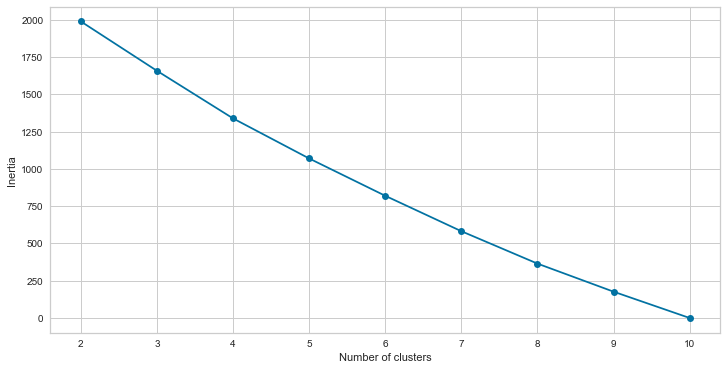

In [45]:


Toronto_grouped_clustering3 = Toronto_grouped.drop('Borough', 1)

# Standardizing the data
data_scaled = StandardScaler().fit_transform(Toronto_grouped_clustering3)


# fitting multiple k-means algorithms and storing the values in an empty list
SSE2 = []
for cluster in range(2,11):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE2.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(2,11), 'SSE2':SSE2})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE2'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

/Users/luizumbertosica/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/luizumbertosica/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/luizumbertosica/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


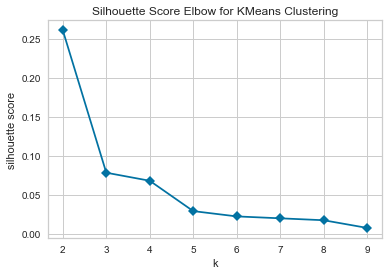

In [46]:
# Instantiate a scikit-learn K-Means model
model2 = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model2, k=(2,10), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(data_scaled)    
visualizer.poof()

We cannot estimate an optimal k parameter from the inconclusive results obtained by the Elbow and Silhouette Methods. A further investigation to choose a more suitable method is out of the scope of the present project, which is to illustrate the application of web scrapping, Foursquare API and, k-means clustering to explore boroughs in Toronto. We will proceed considering 5 clusters.

In [47]:
Toronto_grouped_clustering = Toronto_grouped.drop('Borough', 1)

# set number of clusters
kclusters = 5#4#10#6#9#5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_scaled)#Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 1, 0, 0, 3, 1, 0, 2, 1], dtype=int32)

In [48]:
# Insert a column with the cluster labels

boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

'''
Assigning the information from the df3 dataframe, which has information on postal code, boroughs, 
neighborhoods, latitudes and, longitudes in Toronto.
'''

Toronto_merged = df3

According to the book [Python for Data Analysis](https://www.amazon.com.br/Python-Data-Analysis-Wrangling-IPython-ebook/dp/B075X4LT6K/ref=sr_1_2?gclid=CjwKCAiAlajvBRB_EiwA4vAqiAXXwy4WUAHHiL4Zs-EpMigSUxEBB5h8Y5jetb3UI01o2Skc3NFrThoCDLcQAvD_BwE&hvadid=326918364388&hvdev=c&hvlocphy=1001655&hvnetw=g&hvpos=1t3&hvqmt=b&hvrand=7109147701698772108&hvtargid=kwd-298947497743&keywords=python+for+data+analysis&qid=1575699773&sr=8-2), the dataframe's join method performs a left join on the join keys, exactly preserving the left dataframe's row index. Besides, it also supports joining the index of the passed dataframe on one of the columns of the calling dataframe. Therefore, we are passing converting the "Borough column" of the boroughs_venues_sorted dataframe as its indexes and then set on='Borough' (the calling dataframe). 

In [49]:
Toronto_merged = Toronto_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

Toronto_merged

,Postcode,Borough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.7545,-79.3300,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
1,M4A,North York,Victoria Village,43.7276,-79.3148,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
2,M5A,Downtown Toronto,Harbourfront,43.6555,-79.3626,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.7223,-79.4504,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
4,M7A,Queen's Park,Not assigned,43.6641,-79.3889,1,Gym,Sushi Restaurant,Italian Restaurant,Seafood Restaurant,Burrito Place,Coffee Shop,Bubble Tea Shop,Ramen Restaurant,Gastropub,Beer Bar
5,M9A,Downtown Toronto,Downtown Toronto,43.6662,-79.5282,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
6,M1B,Scarborough,"Rouge,Malvern",43.8113,-79.1930,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Convenience Store,Intersection,Bank,Chinese Restaurant,Discount Store
7,M3B,North York,Don Mills North,43.7450,-79.3590,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
8,M4B,East York,"Woodbine Gardens,Parkview Hill",43.7063,-79.3094,0,Indian Restaurant,Coffee Shop,Restaurant,Bank,Burger Joint,Pizza Place,Sandwich Place,Fast Food Restaurant,Electronics Store,Sporting Goods Shop
9,M5B,Downtown Toronto,"Ryerson,Garden District",43.6572,-79.3783,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar


Now, let us proceed to visualize the resulting clusters.

In [50]:
# Create map
map_clusters = folium.Map(location=[lat_downtown_Toronto, lng_downtown_Toronto], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['latitude'], Toronto_merged['longitude'], Toronto_merged['Borough'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
# Verifying
Toronto_merged['Cluster Labels'].unique()

array([3, 4, 1, 0, 2])

Now, let us visualize the information of the boroughs as well as the venue's categories of each cluster.

In [52]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 0                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Convenience Store,Intersection,Bank,Chinese Restaurant,Discount Store
8,East York,0,Indian Restaurant,Coffee Shop,Restaurant,Bank,Burger Joint,Pizza Place,Sandwich Place,Fast Food Restaurant,Electronics Store,Sporting Goods Shop
11,Etobicoke,0,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Beer Store,Liquor Store,Sushi Restaurant,Chinese Restaurant,Burrito Place,Supermarket
12,Scarborough,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Convenience Store,Intersection,Bank,Chinese Restaurant,Discount Store
14,East York,0,Indian Restaurant,Coffee Shop,Restaurant,Bank,Burger Joint,Pizza Place,Sandwich Place,Fast Food Restaurant,Electronics Store,Sporting Goods Shop
17,Etobicoke,0,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Beer Store,Liquor Store,Sushi Restaurant,Chinese Restaurant,Burrito Place,Supermarket
18,Scarborough,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Convenience Store,Intersection,Bank,Chinese Restaurant,Discount Store
22,Scarborough,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Convenience Store,Intersection,Bank,Chinese Restaurant,Discount Store
23,East York,0,Indian Restaurant,Coffee Shop,Restaurant,Bank,Burger Joint,Pizza Place,Sandwich Place,Fast Food Restaurant,Electronics Store,Sporting Goods Shop
26,Scarborough,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store,Convenience Store,Intersection,Bank,Chinese Restaurant,Discount Store


In [53]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 1                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Queen's Park,1,Gym,Sushi Restaurant,Italian Restaurant,Seafood Restaurant,Burrito Place,Coffee Shop,Bubble Tea Shop,Ramen Restaurant,Gastropub,Beer Bar
16,York,1,Park,Brewery,Fast Food Restaurant,Playground,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Beer Store,Field,Grocery Store
19,East Toronto,1,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub,Park,Ice Cream Shop,Yoga Studio,Bakery,Sandwich Place
21,York,1,Park,Brewery,Fast Food Restaurant,Playground,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Beer Store,Field,Grocery Store
41,East Toronto,1,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub,Park,Ice Cream Shop,Yoga Studio,Bakery,Sandwich Place
47,East Toronto,1,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub,Park,Ice Cream Shop,Yoga Studio,Bakery,Sandwich Place
54,East Toronto,1,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub,Park,Ice Cream Shop,Yoga Studio,Bakery,Sandwich Place
56,York,1,Park,Brewery,Fast Food Restaurant,Playground,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Beer Store,Field,Grocery Store
61,Central Toronto,1,Park,Sandwich Place,Café,Coffee Shop,Italian Restaurant,American Restaurant,Gym,Restaurant,Dessert Shop,Thai Restaurant
62,Central Toronto,1,Park,Sandwich Place,Café,Coffee Shop,Italian Restaurant,American Restaurant,Gym,Restaurant,Dessert Shop,Thai Restaurant


In [54]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 2                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,West Toronto,2,Coffee Shop,Café,Bar,Bakery,Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Park,Gift Shop
37,West Toronto,2,Coffee Shop,Café,Bar,Bakery,Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Park,Gift Shop
43,West Toronto,2,Coffee Shop,Café,Bar,Bakery,Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Park,Gift Shop
69,West Toronto,2,Coffee Shop,Café,Bar,Bakery,Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Park,Gift Shop
75,West Toronto,2,Coffee Shop,Café,Bar,Bakery,Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Park,Gift Shop
80,West Toronto,2,Coffee Shop,Café,Bar,Bakery,Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Park,Gift Shop


In [55]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 3                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
1,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
3,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
7,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
10,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
13,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
27,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
28,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
33,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store
34,North York,3,Clothing Store,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Sandwich Place,Restaurant,Sushi Restaurant,Japanese Restaurant,Grocery Store


In [56]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 4                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
5,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
9,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
15,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
20,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
24,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
25,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
30,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
36,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar
42,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bar,Steakhouse,Beer Bar


The insights observed, considering the five most common venues categories per cluster, are summarized below; 

- __Cluster 0__: The boroughs contained in this cluster have shown a balanced venues categories, in which you can find restaurants, fast foods, coffee shops,  pharmacies, grocery stores and, banks, pretty much everything that any person could need.
- __Cluster 1__: There is a focus on gastronomical variety here, you can find several types of restaurants. Besides, entertainment for kids (playgrounds) and for adults (pubs) is available.
- __Cluster 2__: Although this cluster has a lot of similarities with cluster 4, with a careful look we can see a focus on nightlife due to the bar venue category being the third most common.
- __Cluster 3__: Although this cluster is not balanced as cluster 0, you can still find good options for coffee shops, food, clothing and to take a walk in the park with your family.
- __Cluster 4__: It has just one borough, and its venues categories represent a business center, with a focus on coffee shops and cafés, having hotels, restaurants, and bakeries available for a possible need.